In [121]:
import numpy
import scipy
import matplotlib.pyplot as plt
import soundfile
import os
import subprocess
import concurrent.futures
import multiprocessing  
import IPython

chemin_son = "Son.wav"

signal, fréquence_échantillonnage = soundfile.read(chemin_son)

signal = signal[:1000000]

<h1 align="center">🎵 FLAC 🎵</h1>

Présenté par Alix ANNERAUD et Haijiao YU

# ✅ Caractéristiques

- **Type de données**: 🎵
- **Conteneur**:
  - `.flac`
  - `.ogg` (Vorbis)
  - `.mkv` (Matroska)
  - `.mp4` (MPEG-4 Part 14)
- **Développé par**: Xiph.Org Foundation
- **Première version**: 20 juillet 2001
- **Fréquence d'échantillonnage**: variable ($1$ Hz à $1 048 570$ Hz)
- **Profondeur d'échantillonnage**: variable ($4$ bits à $32$ bits)
- **Detection d'erreur**: ✅
- **Compression**: ✅
- **Perte de données**: ❌ 


Le **Free Lossless Audio Codec** (FLAC) est un codec audio sans perte de données.

Il a été développé par la Xiph.Org Foundation et sa première version a été publiée le 20 juillet 2001.

Contrairement à d'autres codecs audio tels que MP3 et AAC, FLAC ne supprime aucune donnée audio lors de la compression. Cela signifie que la qualité audio est conservée à 100% et que le fichier audio compressé , une fois décompressé, est identique à l'original.

FLAC est un format audio populaire pour les audiophiles et les professionnels de l'audio en raison de sa qualité audio sans perte et de sa compatibilité avec de nombreux lecteurs multimédias et appareils audio.

Il supporte des échantillonnages variables et peut compresser des fichiers audio jusqu'à 50 à 70% de leur taille d'origine.

# 📈 Numérisation du signal 

```mermaid
flowchart LR
    Signal_analogique[Signal analogique]
    Signal_numérique[Signal numérique]
    Signal_encodé[Signal encodé]

    Signal_analogique -->|Echantillonnage| Signal_numérique
    Signal_numérique -->|Encodage| Signal_encodé

    Signal_encodé -->|Décodage| Signal_numérique
    Signal_numérique -->|Reconstruction| Signal_analogique
```

- **Signal analogique**: Signal sonore continu dans le temps (exemple : vinyle).
- **Signal numérique**: Signal discret en temps et en amplitude (exemple : fichier WAV).
- **Signal encodé**: Signal numérique compressé (exemple : fichier FLAC, MP3, AAC, etc.).

1. **Introduction au FLAC**
   - Importance de comprendre la numérisation du signal pour comprendre le FLAC.

2. **Signal Analogique**
   - Le signal sonore initial est analogique.
   - Continu dans le temps et l'amplitude.

3. **Échantillonnage**
   - Acquisition numérique du signal.
   - Mesure à intervalles réguliers.

4. **Encodage Numérique**
   - Le signal numérique est encodé pour le stockage.
   - Utilisation d'un codec audio.
   - Compression possible, avec ou sans perte.

5. **FLAC**
   - Codec audio avec compression sans perte.

# 🔄 Principe d'encodage

Nous allons maintenant étudier le principe d'encodage du FLAC étape par étape.

## 🐀 Cobaye

Voici le signal sur lequel nous allons travailler :

In [122]:
nombre_échantillons, nombre_canaux = signal.shape

print(f"Chemin: {chemin_son}")
print(f"Durée: {int(nombre_échantillons / fréquence_échantillonnage)} secondes")
print(f"Nombre de canaux: {nombre_canaux}")
print(f"Fréquence d’échantillonnage: {fréquence_échantillonnage} Hz")
print(f"Encodage: {signal.dtype}")
print(f"Nombre d’échantillons par canal: {nombre_échantillons}")

Chemin: Son.wav
Durée: 20 secondes
Nombre de canaux: 2
Fréquence d’échantillonnage: 48000 Hz
Encodage: float64
Nombre d’échantillons par canal: 1000000


Tout d'abord, laissez moi vous présenter notre cobaye:

- C'est une musique qui dure X secondes
- Composé de 2 canaux audio (c'est normal pour une musique stéréo) 
- Échantillonné à X Hz.
- Les échantillons sont codés sur 16 bits, cependant, la librairie python que nous utilisons pour lire le fichier audio nous renvoie une matrice numpy de flottants sur 64 bits où les valeurs sont comprises entre -1 et 1.
- Au total nous avons X échantillons par canal.

In [123]:
%%capture out

plt.figure(figsize=(10, 3))
plt.title("Extrait du signal")
plt.plot(signal[200000:210000, 0], label="Canal gauche")
plt.plot(signal[200000:210000, 1], label="Canal droit")
plt.legend()
plt.show()

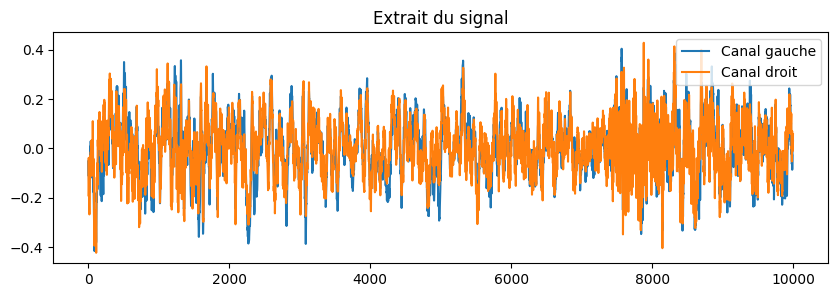

In [124]:
out()

## 🔪 Division en blocs


```mermaid
graph TB
    Signal_audio[Signal audio]

    Signal_audio -->Canal_1[Canal 1]
    Signal_audio -->Canal_2[Canal 2]
    Signal_audio -->Canal_...[Canal ...]

    Canal_1 -->Bloc_11[Bloc 1]
    Canal_1 -->Bloc_12[Bloc 2]
    Canal_1 -->Bloc_1...[Bloc ...]

    Canal_2 -->Bloc_21[Bloc 1]
    Canal_2 -->Bloc_22[Bloc 2]
    Canal_2 -->Bloc_2...[Bloc ...]

    Canal_... -->Bloc_...1[Bloc 1]
    Canal_... -->Bloc_...2[Bloc 2]
    Canal_... -->Bloc_......[Bloc ...]
```

1. **Rappels**
   - **Canaux**:
     - Un signal audio stéréo est composé de deux canaux audio.
     - Chaque canal audio est traité indépendamment.
   - **Échantillons**
      - Un échantillon représente l'amplitude du signal audio à un instant donné.
      - Encodage sur plusieurs bits (8, 16, 24, 32 bits, etc.).

2. **Division du Signal Audio**
   - Le signal audio numérique est divisé en blocs.
   - Chaque bloc contient un nombre identique d'échantillons pour chaque canal audio.

3. **Taille des Blocs**
   - Taille typique : 4096 échantillons par canal.

4. **Traitement Indépendant des Blocs**
   - Chaque bloc est traité indépendamment.
   - Possède ses propres métadonnées de compression.
   - Exemple de métadonnées : dictionnaire de prédiction pour la compression d'Huffman.

5. **Remplissage des Blocs**
   - Si le signal audio ne se divise pas parfaitement en blocs, le dernier bloc est complété par des échantillons nuls (padding).

In [125]:
def division_par_bloc(signal, taille_bloc):   
    nombre_canaux = signal.shape[1]
    
    nombre_blocs = (len(signal) + taille_bloc - 1) // taille_bloc
    blocs = numpy.zeros((nombre_blocs, taille_bloc, nombre_canaux))
    
    for i in range(nombre_blocs):
        début = i * taille_bloc
        fin = min(début + taille_bloc, len(signal))
        blocs[i, :fin - début] = signal[début:fin]
        
    return blocs

taille_bloc = 4096
blocs = division_par_bloc(signal, taille_bloc)

nombre_blocs, taille_blocs, nombre_canaux = blocs.shape

print(f"Nombre de blocs: {nombre_blocs}")
print(f"Taille des blocs: {taille_bloc}")
print(f"Nombre de canaux: {nombre_canaux}")

Nombre de blocs: 245
Taille des blocs: 4096
Nombre de canaux: 2


1. **Division du Signal Audio**
   - Division du signal audio en blocs de 4096 échantillons par canal.

2. **Équivalence avec Reshape**
   - Cette division est équivalente à un reshape.

3. **Structure des Échantillons**
   - Les échantillons sont stockés dans des tableaux, eux-mêmes stockés dans un tableau.
   - Il s'agit d'une convention.

4. **Complexité de la Structure**
   - L'inverse aurait été plus simple à gérer.

## 🔍 Décorrélation inter-canal (optionnel)

$$
\begin{align*}
    x_\text{central} &= \frac{x_\text{gauche} + x_\text{droite}}{2} \\
    x_\text{latéral} &= x_\text{gauche} - x_\text{droite}
\end{align*}
$$

Réduit la redondance

1. **Décorrélation Inter-Canal**
   - Objectif : Éliminer la redondance pour la compression.

2. **Principe Fondamental**
   - Utilisation de la similarité entre les deux canaux d'un signal audio stéréo.

3. **Stockage des Canaux**
   - Partie commune (moyenne) stockée dans le canal central.
   - Différence entre les deux canaux stockée dans le canal latéral.

4. **Avantages**
   - Canal central proche des signaux initiaux.
   - Canal latéral de faible amplitude, facilement compressible.

5. **Conditions d'Utilisation**
   - Étape optionnelle, utile uniquement pour les signaux stéréo.
   - Non applicable aux signaux mono.
   - Adaptation nécessaire pour les signaux 5.1/7.1.

In [126]:
def décorréler(signal):
    signal_décorrélé = numpy.zeros(signal.shape)
        
    signal_décorrélé[:, :, 0] = signal.mean(axis=2)
    signal_décorrélé[:, :, 1] = signal[:, :, 1] - signal[:, :, 0]
    
    return signal_décorrélé

signal_décorrélé = décorréler(blocs)

In [127]:
%%capture out

bloc = 12

Axes, Figures = plt.subplots(2, 1)

minimum = min(blocs[bloc, :, 0].min(), blocs[bloc, :, 1].min())
maximum = max(blocs[bloc, :, 0].max(), blocs[bloc, :, 1].max())

Figures[0].set_title("Signal original")
Figures[0].plot(blocs[bloc, :, 1], label=f"Droit ($\sigma = {blocs[bloc, :, 1].std():.2f}$)")
Figures[0].plot(blocs[bloc, :, 0], label=f"Gauche ($\sigma = {blocs[bloc, :, 0].std():.2f}$)")
Figures[0].set_ylim(minimum, maximum)
Figures[0].legend()

Figures[1].set_title("Signal décorrélé")
Figures[1].plot(signal_décorrélé[bloc, :, 0], label=f"Central ($\sigma = {signal_décorrélé[bloc, :, 0].std():.2f}$)")
Figures[1].plot(signal_décorrélé[bloc, :, 1], label=f"Latéral ($\sigma = {signal_décorrélé[bloc, :, 1].std():.2f}$)")
Figures[1].set_ylim(minimum, maximum)
Figures[1].legend()

plt.tight_layout()
plt.show()

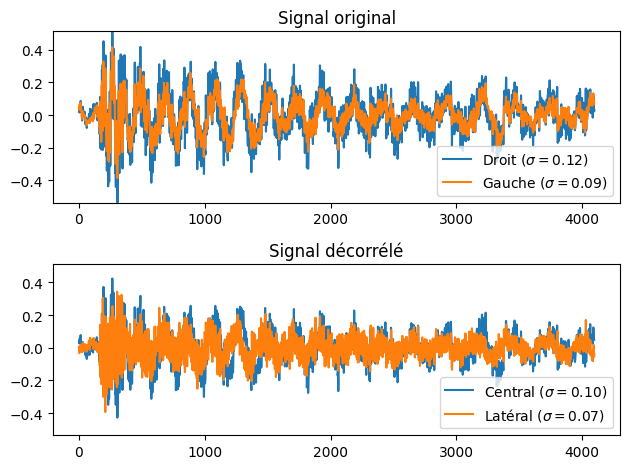

In [128]:
out()

On constate que l'amplitude du signal latéral est souvent plus faible que celle des signaux d'origine.

## 📐 Modélisation

On cherche à approximer le signal avec une fonction:

$$
x_n = f(x_{n-1}, x_{n-2}, \ldots, x_{n-p}) + e_n
$$

Où:
- $x_n$ : échantillon à l'instant $n$
- $f$ : fonction de prédiction
- $e_n$ : les résidus
- $p$ : ordre de la prédiction

On cherche : 

$$
\min_{f} \sum_{n=1}^N (x_n - f(x_{n-1}, x_{n-2}, \ldots, x_{n-p}))^2
$$

1. **Modélisation du Signal Audio**
   - Objectif : Modéliser le signal audio.

2. **Approximation par une Fonction**
   - La fonction prend en entrée les $p$ échantillons précédents.
   - $p$ est l'ordre de la prédiction.
   - La fonction prédit l'échantillon suivant.

3. **Minimisation de l'Erreur**
   - Trouver la fonction $f$ qui minimise l'erreur quadratique moyenne.
   - Comparaison entre les échantillons réels et prédits.

4. **Résultats de la Modélisation**
   - Obtention des $p$ coefficients de la fonction $f$.
   - Résidus $e_n$ de faible amplitude, facilement compressibles.

5. **Objectif Final**
   - Minimiser $e_n$ pour réduire la quantité d'information à stocker.
   - Deux méthodes disponibles pour atteindre cet objectif.

### 📈 Ajustement de polynômes simples

On a $f$ qui est un polynôme de degré $p$:

$$f(x) = a_0 + a_1 x_{n-1} + a_2 x_{n-2} + \ldots + a_p x_{n-p}$$

La première méthode pour approximer le signal est l'ajustement de polynômes simples.

$f$ est alors un polynôme de degré $p$, où les $p$ coefficients $a_0, a_1, \ldots, a_p$ permettent de prévoir l'échantillon suivant en fonction des $p$ échantillons précédents.

Nous cherchons à trouver ces coefficients $a_0, a_1, \ldots, a_p$ qui minimisent l'erreur quadratique moyenne afin d'avoir les résidus les plus faibles possibles.

$$
\begin{align*}
    a_0 &= \frac{\sum x_n}{N} \\
    a_1 &= \frac{\sum x_n x_{n-1}}{\sum x_{n-1}^2} \\
    a_2 &= \frac{\sum x_n x_{n-2}}{\sum x_{n-2}^2} \\
    &\vdots \\
    a_p &= \frac{\sum x_n x_{n-p}}{\sum x_{n-p}^2}
\end{align*}
$$

Voici les formules pour calculer les coefficients $a_0, a_1, \ldots, a_p$. Ces formules sont dérivées de la minimisation de l'erreur quadratique moyenne.

Cette méthode est simple et efficace lors de l'encodage mais elle ne permet pas de modéliser des signaux complexes efficacement, on se retrouve donc avec des résidus plus important que la méthode suivante, ce qui nécessite de stocker plus d'informations.

### 🔮 Codage prédictif linéaire

On a :

$$f(x) = \sum_{i=1}^p a_i x_{n-i}$$

On peut représenter les résidus $e_n$ comme un processus AR(p) :

$$
    R_i = \sum_{j=1}^{p} a_j R_{i-j}
$$

Où :
- $R_i$ est la matrice d'autocorrélation
- $a_j$ sont les coefficients de prédiction
- $p$ est l'ordre de prédiction

Résolu par la méthode de **Levinson-Durbin**.

- Une autre méthode pour approximer le signal est le codage prédictif linéaire.
- La fonction $f$ est une somme pondérée des $p$ échantillons précédents.
- Les résidus $e_n$ peuvent être représentés comme un processus AR(p).
- $R_i$ est la fonction d'auto-corrélation et $a_j$ sont les coefficients de prédiction.
- Cette méthode est lourde en termes de calcul.
- Elle nécessite de calculer la matrice d'auto-corrélation et de résoudre un système d'équations linéaires.
- Même en traitant un bloc à la fois, la complexité est $O(np^2)$.
- Cependant, elle modélise efficacement des signaux complexes.
- Cela permet de réduire l'amplitude des résidus.

In [129]:
def codage_prédictif_linéaire_bloc(signal, ordre):
    autocorrelation = scipy.signal.correlate(signal, signal, mode="full")
    autocorrelation = autocorrelation[len(signal) - 1 :]

    R = scipy.linalg.toeplitz(autocorrelation[:ordre])

    r = autocorrelation[1 : ordre + 1]

    coefficients = numpy.linalg.solve(R, r)

    return -coefficients

In [130]:
def codage_prédictif_linéaire(signal, ordre):
    nombre_blocs, taille_bloc, nombre_canaux = signal.shape
    coefficients = numpy.zeros((nombre_blocs, nombre_canaux, ordre))

    for index_bloc in range(nombre_blocs):
        for index_canal in range(nombre_canaux):
            bloc = signal[index_bloc, :, index_canal]

            coefficients[index_bloc, index_canal, :] = codage_prédictif_linéaire_bloc(
                bloc, ordre
            )

    return coefficients

In [131]:
def calculer_résidus(signal, coefficients):
    nombre_blocs, taille_bloc, nombre_canaux = signal.shape
    résidus = numpy.zeros((nombre_blocs, taille_bloc, nombre_canaux))

    for index_bloc in range(nombre_blocs):
        for index_canal in range(nombre_canaux):
            bloc = signal[index_bloc, :, index_canal]

            predicition = scipy.signal.lfilter(
                [0] + -coefficients[index_bloc, index_canal], [1], bloc
            )

            résidus[index_bloc, :, index_canal] = bloc - predicition

    return résidus

In [132]:
ordre = 10

coefficients = codage_prédictif_linéaire(signal_décorrélé, ordre)
résidus = calculer_résidus(signal_décorrélé, coefficients)

In [133]:
%%capture out

bloc = 12

Figures, Axes = plt.subplots(2, 1)

Axes[0].set_title("Signal décorrélé central")
Axes[0].plot(signal_décorrélé[bloc, :, 0])

Axes[1].set_title("Résidus central")
Axes[1].plot(résidus[bloc, :, 0])

plt.tight_layout()
plt.show()

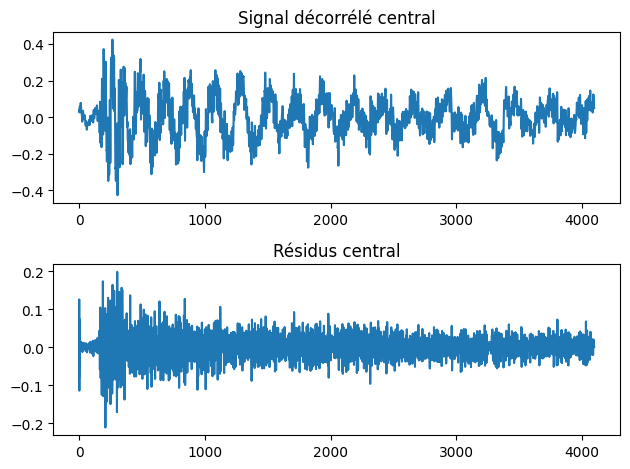

In [134]:
out()

In [135]:
%%capture out

bloc = 10

Axes, Figures = plt.subplots(2, 1)

Figures[0].set_title("Distribution du signal décorrélé")
Figures[0].hist(signal_décorrélé[bloc, :, 0], bins=100)

Figures[1].set_title("Distribution des résidus")
Figures[1].hist(résidus[bloc, :, 0], bins=100)

plt.tight_layout()

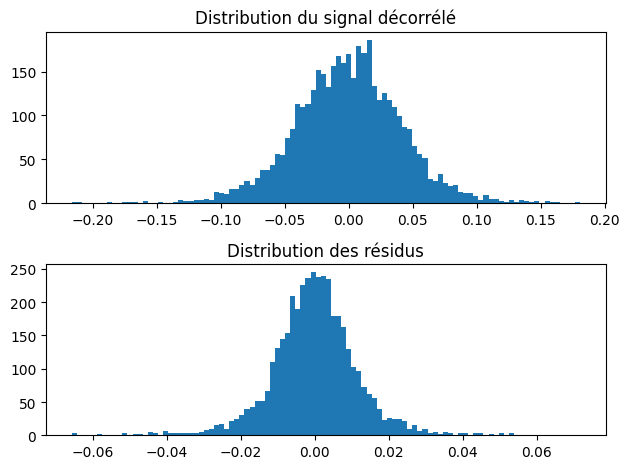

In [136]:
out()

On constate que la distribution des résidus quantifiés est nettement plus resserrée et homogène. Cela se rapproche d'une distribution gaussienne. Cette distribution n'est cependant pas une distribution gaussienne mais une distribution de Laplace (ou double exponentielle).

## 📊 Quantification

Passage de flottants à entiers.

$$
x_\text{quantifié} = \text{arrondir}(x_\text{flottant} \times 2^{b - 1})
$$

où $b$ est la profondeur de bits.

- Nous allons maintenant procéder à la quantification des échantillons.
- Cette étape est nécessaire car les calculs précédents ont été effectués sur des flottants 64 bits.
- Cependant, le FLAC ne stocke que des entiers.
- La quantification permet de convertir les flottants en entiers.
- La formule de quantification est un arrondi de la valeur flottante multipliée par $2^{b-1}$.
- $b$ est la profondeur de bits de l'échantillon de sortie, généralement 8, 16, 24 ou 32 bits.
- La profondeur de bits dépend de la qualité audio souhaitée.

In [137]:
def quantifier(signal, profondeur):
    return numpy.round(signal * 2**(profondeur - 1))

In [138]:
résidus_quantifiés = quantifier(résidus, 16)
coefficients_quantifiés = quantifier(coefficients, 16)

In [139]:
%%capture out

bloc = 10

figures, axes = plt.subplots(2, 1)

axes[0].set_title("Résidus")
axes[0].plot(résidus[bloc, :, 0])

axes[1].set_title("Résidus quantifiés à 16 bits")
axes[1].plot(résidus_quantifiés[bloc, :, 0])

plt.tight_layout()
plt.show()

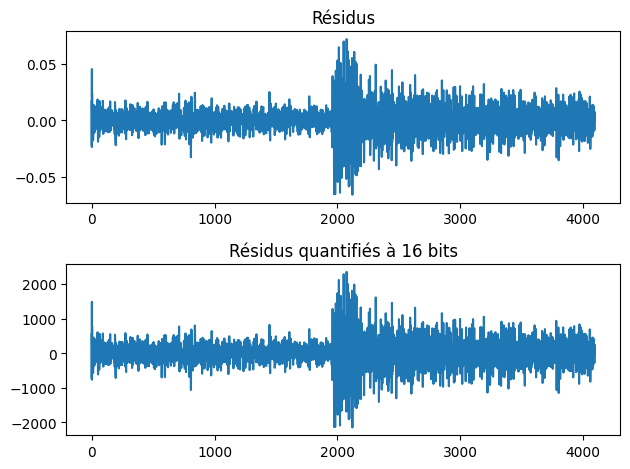

In [140]:
out()

On peut voir que la quantification ne déforme pas le signal audio, elle modifie seulement son amplitude.

## 🗜️ Compression

Les résidus sont des nombres entiers très petits (peu de bits significatifs)

Codage à longueur variable :

- **Golomb-Rice**
    - Rapide à encoder et à décoder.
    - Efficace pour les distributions de symboles géométriques ou exponentielles.
- **Huffman**
    - Plus lent à encoder et à décoder.
    - Efficace pour les distributions de symboles non uniformes.

- Nous avons maintenant les coefficients de prédiction $a_0, a_1, \ldots, a_p$ et les résidus $e_n$.
- Nous allons chercher à compresser ces résidus.
- Compresser les coefficients de prédiction n'est pas efficace car ce sont des nombres flottants aux valeurs très variables.
- Les résidus, de faible amplitude, sont très compressibles.
- Nous utiliserons un codage à longueur variable pour les résidus.
- Les deux méthodes les plus utilisées sont le codage de Golomb-Rice et le codage de Huffman.

### 🌳 Codage d'Huffman

Pour rappel, pour coder des données:

1. Calculer la fréquence d'apparition de chaque symbole.
2. Création d'un arbre binaire.
3. On calcule le dictionnaire de traduction.
4. On traduit les signaux en binaire.
5. On stocke la traduction et l'arbre binaire.

Nous n'allons pas rentrer dans les détails du codage de Huffman vu que nous l'avons déjà vu en Algo et revu en TI, cependant, voici pour rappels sont principe général:
1. On calcule la fréquence d'apparition de chaque symbole que l'on trie par ordre croissant.
2. On crée un arbre binaire où les symboles les plus fréquents sont les plus proches de la racine.
3. On calcule le dictionnaire de traduction qui est une table de correspondance entre les symboles et leur code binaire provenant de l'arbre binaire.
4. On traduit les signaux en binaire en utilisant le dictionnaire de traduction.
5. On stocke la traduction et l'arbre binaire dans le fichier compressé.

Cette méthode est très efficace pour compresser des données avec des distributions de symboles non uniformes, cepandant, elle est plus lente à encoder et à décoder que le codage de Golomb-Rice.

### 🍚 Codage de Golomb-Rice

Pour coder un nombre $N$ avec un paramètre $k$:

1. Calculer le quotient $q$ et le reste $r$ : $N = q \times 2^k + r$.
2. Coder le quotient $q$ en unaire ($q$ fois le bit 1 suivi du bit 0): $q_\text{unaire} = 1^q 0$.
3. Coder le reste $r$ en binaire sur $k$ bits: $r_\text{binaire} = \text{binaire}(r, k)$
4. Combiner les deux parties: $\text{Résultat final} = q_\text{unaire} \, r_\text{binaire}$

Le codage de Golomb-Rice est une méthode de codage à longueur variable qui est très efficace pour les distributions de symboles géométriques ou exponentielles.

Pour coder un nombre $N$ avec un paramètre $k$ (où $k$ est un entier non négatif):

1. On commence par calculer le quotient $q$ et le reste $r$ de la division euclidienne de $N$ par $2^k$.
2. On code le quotient $q$ en unaire, c'est à dire que l'on écrit $q$ fois le bit 1 suivi du bit 0.
3. On code le reste $r$ en binaire sur $k$ bits.
4. On combine les deux parties pour obtenir le résultat final.
5. On stocke le paramètre $k$ qui est généralement fixé à une valeur donnée.
6. On stocke le résultat final.

On déterminera la valeur de $k$ en fonction de la distribution des résidus. Plus les résidus sont proches de 0, plus $k$ sera petit.
Cependant, une expérimentation empiruqe est souvent nécessaire pour déterminer la valeur optimale de $k$.

In [141]:
def encoder_golomb_rice(N, k):
    if N < 0:
        N = (-N << 1) - 1  # Si N est négatif, on l'encode sur 2k + 1 bits
    else:
        N = N << 1  # Sinon, on l'encode sur 2k bits

    quotient = N >> k  # Calcul du quotient
    reste = N & ((1 << k) - 1)  # Calcul du reste

    quotient_unaire = "1" * quotient + "0"  # Encodage du quotient en unaire
    reste_binaire = f"{reste:0{k}b}"  # Encodage du reste en binaire

    return quotient_unaire + reste_binaire  # Concaténation des deux encodages


for i in range(-5, 5):
    print(f"{i:2} -> {encoder_golomb_rice(i, 3)}")

-5 -> 10001
-4 -> 0111
-3 -> 0101
-2 -> 0011
-1 -> 0001
 0 -> 0000
 1 -> 0010
 2 -> 0100
 3 -> 0110
 4 -> 10000


In [142]:
def compresser_block(bloc, k):
    bloc_compresse = ["" for _ in range(bloc.shape[1])]
    for canal, residus_canal in enumerate(bloc.T):
        for résidu in residus_canal:
            bloc_compresse[canal] += encoder_golomb_rice(int(résidu), k)

    return bloc_compresse  

def compresser_lot(blocs, k):
    return [compresser_block(bloc, k) for bloc in blocs]

def compresser_signal(residus):
    k = 10

    # Division en lots (un par coeur)
    lots = numpy.array_split(residus, multiprocessing.cpu_count()) 

    # Execution en parallèle par lot de blocs (beaucoup plus rapide)
    with concurrent.futures.ProcessPoolExecutor() as executor:
        résidus_compresse = list(executor.map(compresser_lot, lots, [k] * len(lots)))

    # Concaténation des lots
    return résidus_compresse

In [143]:
résidus_compresse = compresser_signal(résidus_quantifiés)

taille_résidus = résidus_quantifiés.astype(numpy.int16).nbytes

# Calcul de la taille des résidus compressés
taille_résidus_compresse = 0
for lot in résidus_compresse:
    for bloc in lot:
        for canal in bloc:
            taille_résidus_compresse += len(canal)
taille_résidus_compresse //= 8  # Conversion en octets

print(f"Taille des résidus quantifiés: {taille_résidus} octets")
print(f"Taille des résidus compressés: {taille_résidus_compresse} octets")
print(f"Compression: {(1 - taille_résidus_compresse / taille_résidus) * 100:.2f}%")

Taille des résidus quantifiés: 4014080 octets
Taille des résidus compressés: 3009363 octets
Compression: 25.03%


### 🏖️ Codage par plage

- Principe : `ABBBBBBBBCC` $\rightarrow$ `A1B8C2`
- Permet d'encoder des séquences de symboles identiques.

- Après le codage de Golomb-Rice ou de Huffman, on peut encore compresser les données avec le codage par plage.
- Nous avons déjà vu cette méthode en travaux pratiques.
- Le codage par plage encode des séquences de symboles identiques.
- On remplace une séquence de symboles identiques par le symbole suivi du nombre de répétitions.
- Cette méthode réduit encore la taille du fichier compressé.
- Elle ne déforme pas le signal audio.

## ❌ Correction d'erreur

Dans les métadonnées du fichier FLAC.

- **CRC** : Cyclic Redundancy Check
    - Calcul d'un code de contrôle pour détecter les erreurs.
    - Ajouté à la fin du fichier compressé.
- **MD5** : Message Digest Algorithm 5
    - Calcul d'une empreinte numérique (hash) pour vérifier l'intégrité du fichier.

- Une fois les résidus compressés, nous les stockons dans le fichier FLAC.
- Des erreurs peuvent survenir lors de la transmission ou du stockage du fichier FLAC (car le FLAC peut également fonctionner sur des fichiers en streaming).
- Pour cela, le FLAC intègre des métadonnées de correction d'erreur.
- Il utilise un MD5 pour vérifier l'intégrité du fichier.
- Il utilise également un CRC pour détecter et corriger les erreurs.


# 🔄 Principe du décodage

Nous allons maintenant étudier le principe de décodage du FLAC étape par étape.

le processus de décodage comporte trois étapes principales :

1. Lecture des métadonnées et décodage des résidus

2. Application de la prédiction inverse

3. Reconstruction du signal audio
 

### 📖Lire les métadonnées et décoder les résidus📟

- Interprétation des données compressées.
- Analyse du code :
    - Comptage des "1" consécutifs pour déterminer le quotient $q$.
    - Extraction d’un nombre binaire fixe $k$ pour obtenir le reste $r$.
- Reconstruction de la valeur originale :
$$
N = q * 2^k + r
$$

La première étape consiste à lire les métadonnées et à décoder les résidus. Cela permet d'interpréter les données compressées contenues dans le fichier FLAC.

Le code est analysé en comptant les "1" consécutifs jusqu’à ce qu’un "0" soit rencontré. Cela permet de déterminer le quotient $q$. Ensuite, un nombre binaire de longueur fixe $k$ est extrait à partir du reste du code, représentant le reste $r$.

La valeur originale est alors reconstituée grâce à la formule suivante :
$$ N = q * 2^k + r $$
Dans cette formule, $N$ est la valeur originale reconstituée à partir des données compressées.



In [144]:
def decoder_golomb_rice(code, k):
    quotient = 0
    while code[quotient] == '1': 
        quotient += 1
    
    reste_commence = quotient + 1
    reste = int(code[reste_commence:], 2)  

    d = 2**k
    N = quotient * d + reste

    return N

In [145]:
def decoder_golomb_rice_stream(flux_code, k):
    valeurs_decodees = []
    i = 0

    while i < len(flux_code):
        quotient = 0 # Extraire la partie du quotient q
        
        while i < len(flux_code) and flux_code[i] == '1':
            quotient += 1 # On compte le nombre de '1' consécutifs
            i += 1
        i += 1 # Passer au quotient

        reste = int(flux_code[i:i+k], 2) # Extraire la partie du reste r, on le convert en entier
        i += k # Avancer de k bits pour passer au deuxième
        
        d = 2**k
        N = quotient * d + reste # Calculer la valeur originale N
        valeurs_decodees.append(N)
    
    return valeurs_decodees

In [146]:
def convert_a_matrice(flux_code, k, shape):
    decode = decoder_golomb_rice_stream(flux_code, k) 
    nombre_blocs, taille_bloc, nombre_canaux = shape
    matrice_decodee = numpy.zeros(shape, dtype=int)  # Créer une matrice vide pour stocker les résultats
    i = 0  # Position dans le flux compressé

    for b in range(nombre_blocs):
        for c in range(nombre_canaux):
            for n in range(taille_bloc):
                matrice_decodee[b, n, c] = decode[i]
                i += 1 
    
    return matrice_decodee

In [147]:
#flux_code = résidus_compresse
#print(flux_code)
#matrice_decodee = convert_a_matrice(flux_code, 3, matrice.shape)
#print(f'la matrice décodée obtenue est:\n {matrice_decodee}')
#print(f'la matrice originale est:\n {matrice}')

### 🪄Appliquer la prédiciton inverse 

Nous réalisons la reconstruction pour chaque bloc, chaque canal et chaque échantillon:
- Étape 1: Si $n$ < $p$, donc $x_n$ = $e_n$.
- Étape 2: Sinon, calculer la prédiciton:
$$prédiction = \sum_{i=1}^p a_i x_{n-i}$$
- Étape 3: Ajouter le résidu$e_n$ à la prédiction pour obtenir la valeur finale:
$$x_n = prédiction + e_n$$
- Étape 4: Stocker $x_n$ dans la matrice reconstruite.

Après avoir décodé les résidus, il est nécessaire de reconstruire le signal original à l’aide de la prédiction inverse. Ce processus s’effectue étape par étape, en prenant en compte chaque bloc, chaque canal et chaque échantillon audio.

Étape 1 : 
Tout d'abord, pour les premiers échantillons où $n$ < $p$ (c'est-à-dire lorsqu'il n'y a pas assez d'échantillons précédents pour effectuer une prédiction), la valeur du signal est simplement égale au résidu :
$$ x_n = e_n $$

Étape 2 : 
Une fois que nous disposons d'assez d'échantillons précédents ($n$ ≥ $p$), nous utilisons la formule de prédiction basée sur les valeurs précédemment reconstruites et les coefficients de prédiction $a_i$:
$$prédiction = \sum_{i=1}^p a_i x_{n-i}$$
Ici, nous combinons les $p$ derniers échantillons pour estimer la valeur actuelle $x_n$.

Étape 3 : 
Après avoir calculé la prédiction, nous ajoutons le résidu $e_n$, qui contient les informations manquantes dans la prédiction, pour obtenir la valeur finale de $x_n$:
$$x_n = prédiction + e_n$$ 

Étape 4 :
Finalement, nous stockons les valeur reconstruites dans une matrice pour les utiliser comme référence lors des étapes suivantes.

In [148]:
def décodage_prédictif_linéaire_bloc(résidus, coefficients):
    coefficients = numpy.concatenate(([1], coefficients))
    
    return scipy.signal.lfilter([1], coefficients, résidus)
   
def décodage_prédictif_linéaire(résidus, coefficients):
    nombre_blocs, taille_bloc, nombre_canaux = résidus.shape
    signal_reconstruit = numpy.zeros((nombre_blocs, taille_bloc, nombre_canaux))

    for index_bloc in range(nombre_blocs):
        for index_canal in range(nombre_canaux):
            résidus_bloc = résidus[index_bloc, :, index_canal]
            coefficients_bloc = coefficients[index_bloc, index_canal]

            signal_reconstruit[index_bloc, :, index_canal] = décodage_prédictif_linéaire_bloc(résidus_bloc, coefficients_bloc)

    return signal_reconstruit

def déquantifier(signal, profondeur):
    return signal / (2**(profondeur - 1))
    

In [149]:
nombre_blocs = 113
taille_bloc = 4096
nombre_canaux = 2

résidus_déquantifiés = déquantifier(résidus_quantifiés, 16)
coefficients_déquantifiés = déquantifier(coefficients_quantifiés, 16)

signal_reconstruit = décodage_prédictif_linéaire(résidus_déquantifiés, coefficients_déquantifiés)

### 🎼Reconstruire le signal audio

1. Fusionner les blocs de signal: organiser les données sous forme d’un signal continu.
2. Vérifier et convertir les types de données: s’assurer que le signal est au bon format (entiers $int16$).
3. Normaliser les valeurs: limiter les valeurs du signal dans la plage $[-1, 1]$, puis les convertir en entiers dans la plage $[-32768, 32767]$.
4. Sauvegarder le fichier: enregistrer le signal sous format .wav en utilisant la fréquence d’échantillonnage fournie.


La dernière étape consiste à convertir le signal reconstruit en un fichier audio exploitable.

1. Comme le signal reconstruit est divisé en plusieurs blocs, nous devons les fusionner pour obtenir une séquence audio continue.

2. Les fichiers audio utilisent généralement des entiers 16 bits pour représenter les données. Si le signal reconstruit est en format flottant (avec des valeurs comprises entre -1 et 1), nous effectuons une conversion en entier 16 bits.

3. Nous limitons les valeurs du signal reconstruit à la plage -1 à 1. Ensuite, nous les mettons à l’échelle pour correspondre à la plage des entiers 16 bits, soit de -32 768 à 32 767.

Enfin, nous sauvegardons le signal en format .wav. Pour cela, nous précisons la fréquence d’échantillonnage ainsi que le fichier de sortie.

In [176]:
%%capture out

bloc = 10

Figures, Axes = plt.subplots(3, 1)

Axes[0].set_title("Résidus quantifiés")
Axes[0].plot(résidus_quantifiés[bloc, :, 0])

Axes[1].set_title("Signal reconstruit")
Axes[1].plot(signal_reconstruit[bloc, :, 0]) # Petit fix mais chut

Axes[2].set_title("Signal original")
Axes[2].plot(signal_décorrélé[bloc, :, 0])


plt.tight_layout()
plt.show()

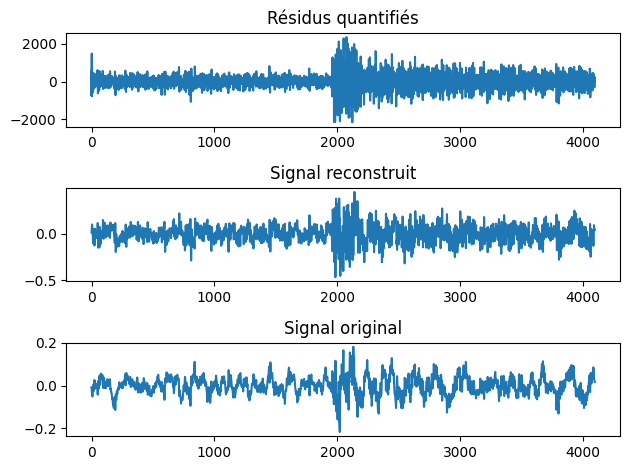

In [177]:
out()

In [178]:
def concaténer_blocs(blocs):
    return numpy.concatenate(blocs, axis=0)

signal_reconstruit_concaténé = concaténer_blocs(signal_reconstruit)

In [179]:
nbr_échantillons, nbr_canaux = signal_reconstruit_concaténé.shape

print(f"Durée: {int(nbr_échantillons / fréquence_échantillonnage)} secondes")
print(f"Nombre de canaux: {nbr_canaux}")
print(f"Fréquence d’échantillonnage: {fréquence_échantillonnage} Hz")
print(f"Encodage: {signal_reconstruit_concaténé.dtype}")
print(f"Nombre d’échantillons par canal: {nbr_échantillons}")

Durée: 20 secondes
Nombre de canaux: 2
Fréquence d’échantillonnage: 48000 Hz
Encodage: float64
Nombre d’échantillons par canal: 1003520


In [180]:
soundfile.write("Son_reconstruit.wav", signal_reconstruit_concaténé, fréquence_échantillonnage)

In [181]:
%%capture out

audio = IPython.display.Audio("Son_reconstruit.wav")

audio

In [182]:
out()

# 🆚 Comparaisons

Nous allons comparer les différentes caractéristiques des formats audio les plus populaires:

## 🆚 Concurrents

| Format | Compression | Perte de données | Développeur | Date de sortie |
|--------|-------------|------------------|-------------|----------------|
| WAV    | ❌         | ❌              | Microsoft | 1991           |
| MP3    | ✅         | ✅              | Fraunhofer institute |  1993 |
| AAC    | ✅         | ✅              | Fraunhofer institute |  1997 |
| OGG    | ✅         | ❌              | Xiph.Org Foundation |   2000 |
| FLAC   | ✅         | ❌              | Xiph.Org Foundation |   2001 |

Nous allons comparer les formats audio les plus populaires.

1. **WAV**
   - Contient les données audio brutes : pas de compression, pas de perte de données.
   - Faible popularité.
   - Développé par Microsoft en 1991.
  
2. **MP3**
    - Compression avec perte.
    - Perte de données.
    - Popularité élevée.
    - Développé par le Fraunhofer Institute en 1993.

3. **AAC**
    - Compression avec perte.
    - Perte de données.
    - Popularité élevée.
    - Développé par le Fraunhofer Institute en 1997.

4. **OGG**
    - Compression sans perte.
    - Pas de perte de données.
    - Faible popularité.
    - Développé par la Xiph.Org Foundation en 2000.

5. **FLAC**

## 🗜️ Efficacité de la compression

1. **AAC**: Compression avec perte (environ 75-90 %).
2. **OGG**: Compression sans perte (environ 30-60 %).
3. **FLAC**: Compression sans perte (environ 30-60 %).
4. **MP3**: Compression avec perte (environ 75-90 %).
5. **WAV**: Pas de compression (0 %).

- L'efficacité de la compression est cruciale pour les formats audio.
- Un taux de compression élevé réduit la taille du fichier audio.
- Cependant, cela peut entraîner une perte de qualité dans le cas des codecs avec perte.
- Comparer la compression entre codecs avec perte et sans perte n'est pas pertinent car leurs objectifs diffèrent.
- Les taux de compression mentionnés sont des fourchettes générales.
- Ces taux peuvent varier en fonction des paramètres de compression.

In [183]:
def get_size(input_file):
    return os.path.getsize(input_file)

def convert_and_get_size(input_file, output_format):
    output_file = f"{os.path.splitext(input_file)[0]}.{output_format}"
    
    try:
        os.remove(output_file)
    except:
        ...
        
    command = ["ffmpeg", "-i", input_file, output_file]
    
    with open(os.devnull, "w") as devnull:
        subprocess.run(command, check=True, stdout=devnull, stderr=devnull)
    
    return get_size(output_file)

labels = ["wav", "flac", "aac", "ogg", "mp3"]
sizes = [
    get_size(chemin_son),
    convert_and_get_size(chemin_son, "flac"),
    convert_and_get_size(chemin_son, "aac"),
    convert_and_get_size(chemin_son, "ogg"),
    convert_and_get_size(chemin_son, "mp3"),
]

In [184]:
%%capture out

plt.title("Comparaison de la taille (ffmpeg)")
plt.bar(numpy.arange(len(labels)), sizes, tick_label=labels)
plt.ylabel("Taille (octets)")

Text(0, 0.5, 'Taille (octets)')

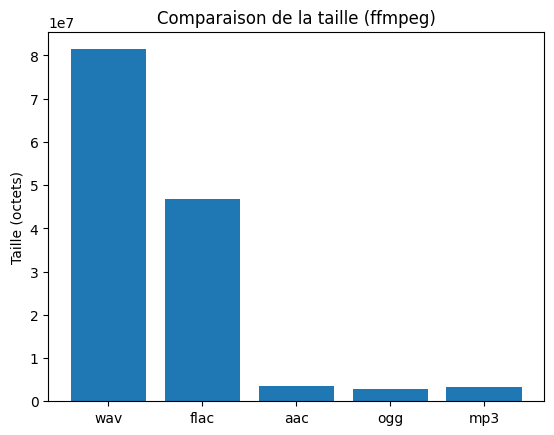

In [185]:
out()

On se rend bien compte que le FLAC est beaucoup plus efficace que le WAV en terme de compression, cependant, il est moins efficace que le MP3, l'OGG et l'AAC, bien que l'AAC soit un peu à la traîne par rapport au MP3 et à l'OGG. Mais bon je ne n'ai rien dis car je ne veux pas compromettre l'exposé de Quentin.

## 🎧 Qualité audio

1. **WAV** et **FLAC**: Qualité audio maximale.
2. **AAC**: Qualité audio très bonne.
3. **OGG**: Qualité audio bonne.
4. **MP3**: Qualité audio bonne.

- La qualité audio n'est pas un critère pertinent pour comparer un codec audio avec perte et sans perte.
- L'évaluation de la qualité audio est subjective.
- Elle dépend de l'oreille de chacun, de l'équipement audio utilisé et de l'environnement d'écoute.
- Bien que des informations soient perdues avec un codec avec perte, si elles sont inaudibles, cela n'a pas d'importance.
- Ces informations inaudibles peuvent être considérées comme redondantes et éliminées.

## ⚒️ Usages

- **WAV**: Anciennement utilisé par les studios d'enregistrement.
- **FLAC**: Utilisé par les studios d'enregistrement, audio-philes, etc.
- **AAC**: Utilisé par Apple sur ses appareils.
- **OGG**: Utilisé pour les jeux vidéos, les vidéos, etc.
- **MP3**: Anciennement utilisé sur les CD, les baladeurs, etc.

Comme vous l'aurez compris, chaque format audio a ses propres avantages et inconvénients et est adapté à des usages spécifiques.

Ainsi pour une Mamie, le MP3 ou l'OGG seront amplement suffisant, même à de faibles débits.

Tandis que les studios d'enregistrement préféreront utiliser le FLAC afin d'économiser de l'espace disque sans perdre en qualité.

# ✅ Conclusion

## 👍 Avantages de FLAC :

- Compression sans perte de qualité sonore
- Conservation totale du signal original
- Format open source et largement adopté

Pour conclure, notre exploration du format FLAC met en évidence ses nombreux avantages en tant que codec audio sans perte. Sa capacité à compresser efficacement les fichiers audio tout en préservant leur qualité d’origine en fait un choix privilégié pour les audiophiles et les professionnels du son.

## 🆚 Comparaisons :

- Excellente efficacité de compression
- Meilleure qualité audio que les formats avec pertes
- Usage adapté aux audiophiles et professionnels

En comparaison avec d’autres formats audio, FLAC se distingue par son efficacité de compression, sa flexibilité grâce à un échantillonnage variable, et sa large adoption dans le domaine open source. Cependant, son utilisation dépend des besoins spécifiques, que ce soit pour le stockage, la diffusion ou la création musicale.


## 🛑 Limites :

- Taille des fichiers plus grande que les formats avec pertes
- Moins répandu sur certains appareils ou plateformes

# 👏 Fin

Merci pour votre attention ! Cette présentation est maintenant terminée.


Nous espérons que cette présentation vous a permis de mieux comprendre les principes techniques et les applications du FLAC. Nous sommes disponibles pour répondre à vos questions ou approfondir certains points.

Merci pour votre attention !

# 📚 Références

- Wikipedia : 
    - [FLAC](https://en.wikipedia.org/wiki/FLAC)
    - [Golomb-Rice Coding](https://en.wikipedia.org/wiki/Golomb_coding)
    - [Yule-Walker Equations](https://en.wikipedia.org/wiki/Autoregressive_model#Yule-Walker_equations)
    - [Levinson-Durbin Algorithm](https://en.wikipedia.org/wiki/Levinson_recursion)
    - [Audio File Formats](https://en.wikipedia.org/wiki/Audio_file_format)
    - [Comparison of Audio Formats](https://en.wikipedia.org/wiki/Comparison_of_audio_coding_formats)
    - [Audio Coding](https://en.wikipedia.org/wiki/Audio_coding_format)
    - [Audio Compression](https://en.wikipedia.org/wiki/Audio_compression_(data))

- Xiph.org :
    - [FLAC - Official Website](https://xiph.org/flac/)
    - [FLAC - Technical Documentation](https://xiph.org/flac/documentation_format_overview.html)
    - [FLAC - Format Specification](https://xiph.org/flac/format.html)
    - [FLAC - Source Code](https://gitlab.xiph.org/xiph/flac)
